In [1]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO
from paco.util.util import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 


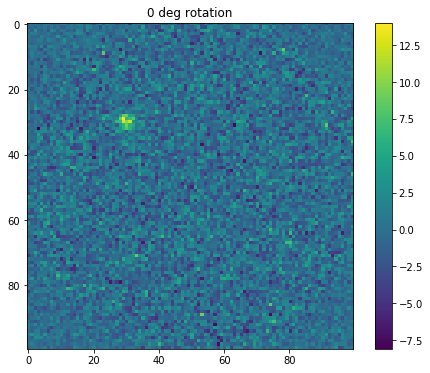

In [2]:
nFrames = 5
angles = np.linspace(0,125,nFrames)#np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 1 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(nFrames)]
X,Y = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2)

#images_signal = [i + s for i in images]
rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(nFrames)])
rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(nFrames)])
rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(nFrames)])

SNR = (s*nFrames)/(np.sqrt(nFrames) * sigma)
sum_ims = np.sum([rotateImage(rot_images[j], -1.0*angles[j]) for j in range(nFrames)], axis = 0)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
im = ax.imshow(sum_ims)
ax.set_title("0 deg rotation")
fig.colorbar(im,ax = ax)




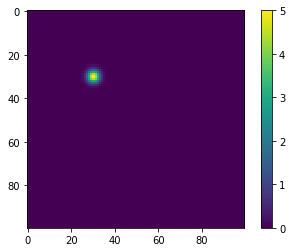

In [4]:
plt.figure()
plt.imshow(SNR)
plt.colorbar()

In [5]:
xx, yy = np.meshgrid(np.arange(-4, 5),np.arange(-4, 5))
s = gaussian2d(xx,yy,1, 2)
s = s/np.sum(s)

fp = fastPACO.FastPACO(angles = angles,
                       patch_size = 49)
fp.setImageSequence(rot_images)
phi0s = np.array([[70,70]])
#%prun fp.PACO(angles,scale = 1, model_name=psftemplate_model, params={"psf_template":s})
a,b = fp.PACO(scale = 1, model_name=psfTemplateModel, model_params={"psf_template":s},cpu = 1)
#a,b = fp.PACO_calc(phi0s,angles)
#a,b= fp.PACO(phi0s,angles)

Precomputing Statistics...
PSF template shape (9, 9)
Running PACO...
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Done


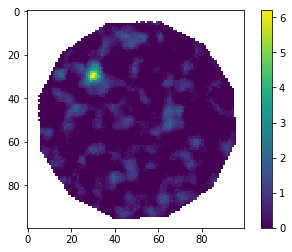

In [8]:
img = b/a
plt.imshow(img)
plt.colorbar()
